In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import sklearn
import pandas as pd
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

In [4]:
print("Torch version:", torchvision.__version__)
print("CUDA version:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())

Torch version: 0.20.1+cu121
CUDA version: 12.1
Is CUDA available: True


In [8]:
#get dataset
train_data = datasets.FashionMNIST(
    root= 'data', #where to downlaod
    train= True, 
    download= True,
    transform= torchvision.transforms.ToTensor(), # how do we want to transfrom data
    target_transform = None #how do we want to transform the labels 
)

test_data = datasets.FashionMNIST(
    root= 'data', #where to downlaod
    train= False, 
    download= True,
    transform= torchvision.transforms.ToTensor(), # how do we want to transfrom data
    target_transform = None #how do we want to transform the labels 
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [19]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [22]:
image, label = train_data[0]

In [24]:
print(f'Image shape: {image.shape} -> [color channel, height, width]')
print(f'Image Label: {class_names[label]}')

Image shape: torch.Size([1, 28, 28]) -> [color channel, height, width]
Image Label: Ankle boot


Image shape: torch.Size([1, 28, 28])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

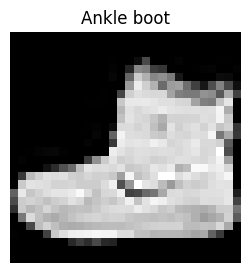

In [43]:
#visualize our data
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.figure(figsize=(3, 3))
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis(False)

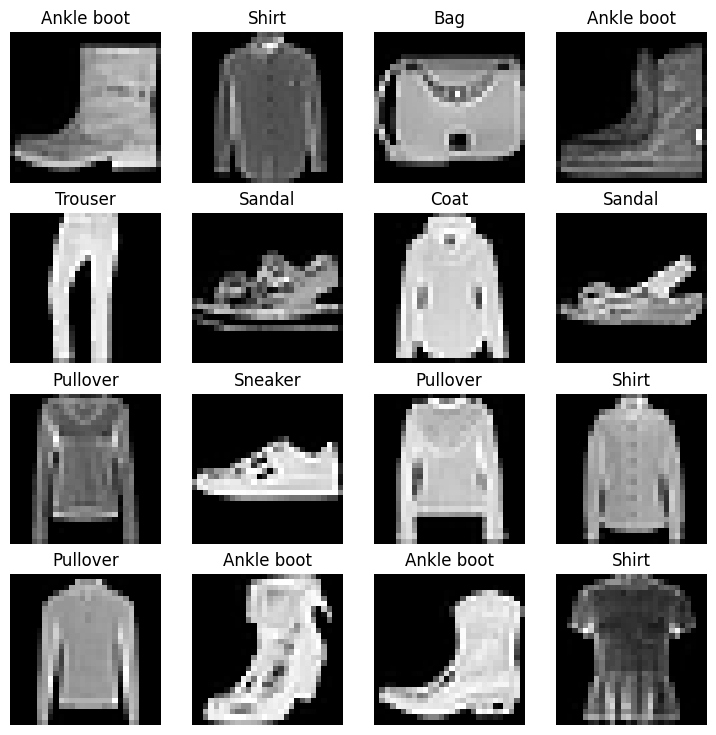

In [44]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap= 'grey')
    plt.title(class_names[label])
    plt.axis(False)

## 2. Dataloader: turns our data into python iterable 
1. we want to turn out data into batches (batch size of 32: 32 images at a time) 
2. It gives our neural network more chances to update its gradients per epoch

In [45]:
from torch.utils.data import DataLoader
#set Batch Size
BATCH_SIZE =32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size= BATCH_SIZE,
                              shuffle=True )
test_dataloader = DataLoader(dataset = test_data,
                             batch_size= BATCH_SIZE,
                             shuffle= False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x27684c1bc50>,
 <torch.utils.data.dataloader.DataLoader at 0x27684bbf210>)

In [46]:
print(f'DataLoader: {train_dataloader, test_dataloader}')
print(f'Length of the train_dataloader {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of the test_dataloader {len(test_dataloader)} batches of {BATCH_SIZE}')

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x0000027684C1BC50>, <torch.utils.data.dataloader.DataLoader object at 0x0000027684BBF210>)
Length of the train_dataloader 1875 batches of 32
Length of the test_dataloader 313 batches of 32


In [49]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size: torch.Size([1, 28, 28])
Label: 9, Label Size: torch.Size([])


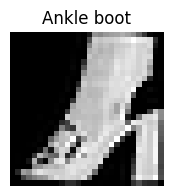

In [52]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.figure(figsize=(2,2))
plt.imshow(img.squeeze(), cmap= 'grey')
plt.title(class_names[label])
plt.axis(False)
print(f"Image Size: {img.shape}")
print(f"Label: {label}, Label Size: {label.shape}")

## Build a Baseline 


In [56]:
#create a flatten layer 
flatten_model = nn.Flatten()

#get a single sample 
x = train_features_batch[0]

#flatten
output = flatten_model(x)

print(f"Shape before Flattening: {x.shape}")
print(f"Shape before Flattening: {output.shape}")

Shape before Flattening: torch.Size([1, 28, 28])
Shape before Flattening: torch.Size([1, 784])


In [62]:
from torch import nn
class FashinMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_shape, out_features=hidden_units),
            nn.Linear(in_features= hidden_units, out_features=output_shape),
        )
    def forward(self, x):
        return self.layer_stack(x)

In [63]:
torch.manual_seed(42)

#setup model with input parameters 
model_0 = FashinMNISTModelV0(input_shape=784, hidden_units= 10, output_shape=len(class_names)).to('cpu')

In [65]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.1680,  0.2322,  0.2701,  0.0274,  0.6386,  0.3092,  0.3212,  0.2810,
         -0.1581, -0.1608]], grad_fn=<AddmmBackward0>)

## Optimzier and evaluation metric

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 1e-3, weight_decay=1e-5)

In [72]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [74]:
from timeit import default_timer as timer 
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    "Prints diff between start time and end time"
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

In [75]:
start_time = timer()

end_time = timer()
print_train_time(start = start_time, end = end_time, device= "cpu")

Train time on cpu: 0.000 seconds


2.9099988751113415e-05

## Creating a training loop and training a model on batches of data
1. Loop through epochs
2. Loop through training batches, perform training steps, calculate loss per batch
3. Loop through test batches, perform test steps, calculate loss per batch
4. Print out results
5. Time it

In [113]:
#Import tqdm progress bar
from tqdm.auto import tqdm

#set seed and timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

#set number of epochs
epochs = 1

#create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n-----------")
    
    #training
    train_loss = 0
    #add a loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        #forward pass 
        y_pred = model_0(X)
        
        #calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        
        #optimizer zero grad
        optimizer.zero_grad()
        
        #backward
        loss.backward()
        
        #optimzer step
        optimizer.step()
        
        #print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")
            
    train_loss /= len(train_dataloader)
    
    #testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            #Forward
            test_pred = model_0(X_test)  

            #Loss 
            test_loss += loss_fn(test_pred, y_test)
            
            #accuracy
            test_acc += accuracy(y_test, test_pred.argmax(dim =1))
        
        #calculate the test loss average per batch
        test_loss /= len(test_dataloader)
        
        #calculate the test acc average per batch
        test_acc /= len(test_dataloader)
    
    #print out results
    print(f"\nTrainLoss : {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc {test_acc:.2f}")
    
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                            end = train_time_end_on_cpu,
                                            device= str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
-----------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 33%|███▎      | 1/3 [00:14<00:28, 14.16s/it]


TrainLoss : 0.3915 | Test Loss: 0.4581 | Test Acc 84.17
Epoch: 1 
-----------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples


 33%|███▎      | 1/3 [00:24<00:49, 24.93s/it]


KeyboardInterrupt: 

## Create Model Evaluation Function

In [87]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            #make predictions
            y_pred = model(X)
            
            #accumulate loss
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim = 1))
        
        #scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"Model Name": model.__class__.__name__,
            "Model_Loss" : loss.item(),
            "Model_acc" : acc}

model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn= loss_fn,
                             accuracy_fn=accuracy)
model_0_results

{'Model Name': 'FashinMNISTModelV0',
 'Model_Loss': 0.4421772360801697,
 'Model_acc': 84.48482428115015}

## Set PyTorch Device

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model 1, buld a model with non-linear and linear layers

In [111]:
class FashinMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_shape: int, output_shape: int):
        super().__init__()
        self.non_linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_shape, out_features=hidden_shape),
            nn.ReLU(),
            nn.Linear(in_features= hidden_shape, out_features=output_shape),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.non_linear_layer(x)

In [112]:
#create instance of model 1
torch.manual_seed(42)
model_1 = FashinMNISTModelV1(input_shape= 784, hidden_shape= 10 ,output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## Create a function for training loop and testing loop
1. training loop - `training_step()`
2. testing loop - `test_step()`

In [108]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):

    """Performs a training with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    #add a loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        #put modeel in train
        model.train()
        #forward pass 
        y_pred = model(X)
        #calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim = 1))
        #optimizer zero grad
        optimizer.zero_grad()
        #backward
        loss.backward()
        #optimzer step
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    #print out results
    print(f"Train Loss : {train_loss:.4f} |  Train Acc {train_acc:.2f}%")

In [109]:
def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
               accuracy_fn, device: torch.device = device):

    """Performs a test with trained model"""
    #testing
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            #Forward
            test_pred = model(X_test)  
            #Loss 
            test_loss += loss_fn(test_pred, y_test)
            #accuracy
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim =1))
        #calculate the test loss average per batch
        test_loss /= len(data_loader)
        #calculate the test acc average per batch
        test_acc /= len(data_loader)
    
    #print out results
    print(f"Test Loss: {test_loss:.4f} | Test Acc {test_acc:.2f}%")

In [115]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 1e-2, weight_decay=1e-5) 
#set number of epochs
epochs = 3

#create optimization and evaluation loop 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n----------")
    train_step(model = model_1, data_loader= train_dataloader, optimizer= optimizer, loss_fn=loss_fn, accuracy_fn=accuracy, device=device)
    test_step(model = model_1, data_loader= test_dataloader, loss_fn= loss_fn, accuracy_fn=accuracy, device=device)
    
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu, end = train_time_end_on_gpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----------
Train Loss : 0.8217 |  Train Acc 70.64%


 33%|███▎      | 1/3 [00:16<00:33, 16.92s/it]

Test Loss: 0.7663 | Test Acc 73.15%
Epoch: 1 
----------
Train Loss : 0.6766 |  Train Acc 75.85%


 67%|██████▋   | 2/3 [00:32<00:16, 16.13s/it]

Test Loss: 0.6853 | Test Acc 75.25%
Epoch: 2 
----------
Train Loss : 0.6577 |  Train Acc 76.47%


100%|██████████| 3/3 [00:46<00:00, 15.46s/it]

Test Loss: 0.7055 | Test Acc 74.82%
Train time on cuda: 46.379 seconds


In [119]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = device):
    """returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            #make predictions
            y_pred = model(X)
            
            #accumulate loss
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim = 1))
        
        #scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"Model Name": model.__class__.__name__,
            "Model_Loss" : loss.item(),
            "Model_acc" : acc}

model_1_results = eval_model(model = model_1,
                             data_loader = test_dataloader,
                             loss_fn= loss_fn,
                             accuracy_fn=accuracy,
                             device = device)
model_1_results, model_0_results

({'Model Name': 'FashinMNISTModelV1',
  'Model_Loss': 0.7054579854011536,
  'Model_acc': 74.8202875399361},
 {'Model Name': 'FashinMNISTModelV0',
  'Model_Loss': 0.4421772360801697,
  'Model_acc': 84.48482428115015})

## Model 2: Building a Convolutional Neural Network

In [222]:
class FashionMNISTModelV2(nn.Module):
    """
    replicates tinyVGG architecture
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [223]:
#set up loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [224]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()
#set number of epochs
epochs = 3
#create optimization and evaluation loop 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n----------")
    train_step(model = model_2, data_loader= train_dataloader, optimizer= optimizer, loss_fn=loss_fn, accuracy_fn=accuracy, device=device)
    test_step(model = model_2, data_loader= test_dataloader, loss_fn= loss_fn, accuracy_fn=accuracy, device=device)
    
train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_on_gpu, end = train_time_end_on_gpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----------
Train Loss : 0.5898 |  Train Acc 78.77%


 33%|███▎      | 1/3 [00:06<00:12,  6.32s/it]

Test Loss: 0.4043 | Test Acc 86.06%
Epoch: 1 
----------
Train Loss : 0.3637 |  Train Acc 87.04%


 67%|██████▋   | 2/3 [00:12<00:06,  6.34s/it]

Test Loss: 0.3532 | Test Acc 87.37%
Epoch: 2 
----------
Train Loss : 0.3232 |  Train Acc 88.42%


100%|██████████| 3/3 [00:19<00:00,  6.48s/it]

Test Loss: 0.3226 | Test Acc 88.56%
Train time on cuda: 19.449 seconds


In [225]:
model_2_results = eval_model(model = model_2,
                             data_loader = test_dataloader,
                             loss_fn= loss_fn,
                             accuracy_fn=accuracy,
                             device = device)
model_2_results

{'Model Name': 'FashionMNISTModelV2',
 'Model_Loss': 0.32255804538726807,
 'Model_acc': 88.55830670926518}

## Evaluate Model Performance

In [228]:
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results["training time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,Model Name,Model_Loss,Model_acc,training time
0,FashinMNISTModelV0,0.442177,84.484824,74.512253
1,FashinMNISTModelV1,0.705458,74.820288,46.378572
2,FashionMNISTModelV2,0.322558,88.558307,19.448668


## Make predicitons

In [233]:
def make_predicitons(model: nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            #prepare sample 
            sample = torch.unsqueeze(sample, dim = 0).to(device) #add an extra dimension and send sample to device
            #forward pass
            pred_logit = model(sample)
            #get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
            #get pred_prob off GPU for further calc
            pred_probs.append(pred_prob.cpu())
    #stach the pred_probs to turn into tensor
    return torch.stack(pred_probs)

In [237]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=10):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [239]:
#make predictions
pred_probs = make_predicitons(model=model_2, data=test_samples)
pred_classes = pred_probs.argmax(dim = 1)
test_labels, pred_classes

([5, 8, 6, 7, 2, 6, 5, 0, 2, 4], tensor([5, 8, 6, 7, 2, 6, 5, 0, 2, 4]))

ValueError: num must be an integer with 1 <= num <= 9, not 10

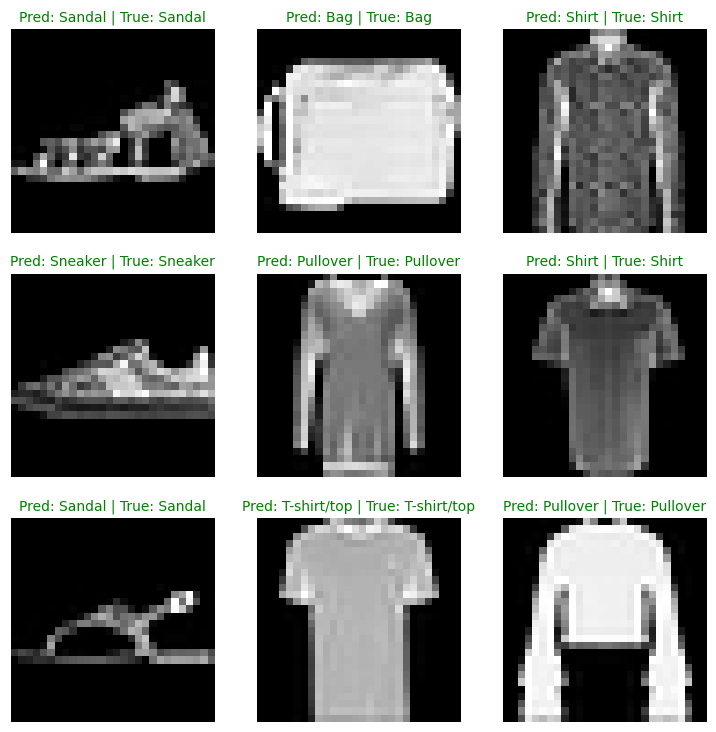

In [243]:
#plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    #create subplot
    plt.subplot(nrows, ncols, i+1)
    #plot target image
    plt.imshow(sample.squeeze(), cmap='grey')
    #pred label
    pred_label = class_names[pred_classes[i]]
    #true label
    true_label = class_names[test_labels[i]]
    #title of plot
    title_text = f"Pred: {pred_label} | True: {true_label}"
    
    #check for eqaulity and change image title
    if pred_label == true_label:
        plt.title(title_text, fontsize = 10, c = "g")
    else:
        plt.title(title_text, fontsize = 10, c = "r")
    plt.axis(False)

## Making a confusion matrix

In [244]:
#make predicitons on trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc = "Making Predictions"):
        X, y = X.to(device), y.to(device)
        #forward pass
        y_logit = model_2(X)
        #get predictions
        y_pred = torch.softmax(y_logit, dim = 1).argmax(dim = 1)
        #append results: appending needs to send to cpu 
        y_preds.append(y_pred.cpu())
#concatenate list of predicitons into a tensor
y_pred_tensor = torch.cat(y_preds)

Making Predictions: 100%|██████████| 313/313 [00:00<00:00, 330.88it/s]


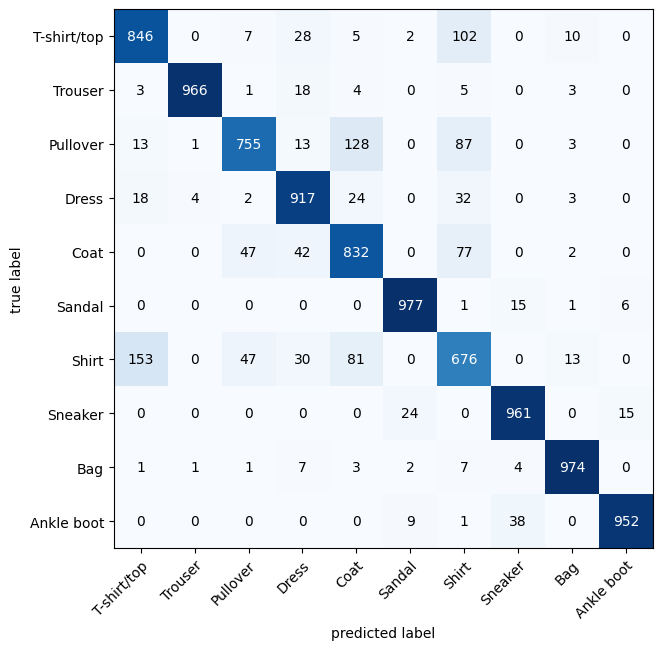

In [253]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#setup confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds = y_pred_tensor, target = test_data.targets)

#plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize = (10 ,7)
)

#Save Model

In [254]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)
# Create model save path
MODEL_NAME = "pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\pytorch_computer_vision_model_2.pth
